In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import random
from scipy import stats
import pickle
import gc

### Set up data

In [2]:
main_dir = '/mnt/Backups/gbrench/repos/indennt/nbs/train_test'
subset_types = ['signal', 'noise', 'dem', 'murp', 'era5']

# exclude non tif files, e.g. metadata
def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

def subset_lists(main_dir, ds_type, subset_types):
    path_d = {}
    fn_list = []
    for type in subset_types:
        path_d[type] = f'{main_dir}/{ds_type}_subsets/{type}/'
        fn_list.append(list_tifs(os.listdir(path_d[type])))
    return path_d, fn_list[0]

test_d, test_list = subset_lists(main_dir, 'test', subset_types)

In [3]:
# define transforms
my_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, path_d, norm_list = [-41, 41, 0, 4374.6372], transform=None, 
                 norm=True, blurnoise=False, random_blur=False, flip=False, invert=False, rotate=False):
        self.file_list = file_list
        self.transform = transform
        self.signal_dir = path_d['signal']
        self.noise_dir = path_d['noise']
        self.dem_dir = path_d['dem']
        self.era5_dir = path_d['era5']
        self.murp_dir = path_d['murp']
        self.norm = norm
        self.blurnoise = blurnoise
        self.random_blur = random_blur
        self.flip = flip
        self.invert = invert
        self.rotate = rotate
        self.igram_min = norm_list[0]
        self.igram_max = norm_list[1]
        self.dem_min = norm_list[2]
        self.dem_max = norm_list[3]
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        signal_path = self.signal_dir+self.file_list[idx]
        noise_path = self.noise_dir+self.file_list[idx]
        dem_path = self.dem_dir+self.file_list[idx]
        era5_path = self.era5_dir+self.file_list[idx]
        murp_path = self.murp_dir+self.file_list[idx]
        
        signal = self.transform(Image.open(signal_path))
        noise = self.transform(Image.open(noise_path))
        dem = self.transform(Image.open(dem_path))
        era5 = self.transform(Image.open(era5_path))
        murp = self.transform(Image.open(murp_path))
        
        # Blur noise
        if self.blurnoise == True: # blur noise to mitigate signal from non atmospheric sources
            if self.random_blur == True:
                blur_params = [[13, 3], [15, 3.5], [17, 4], [19, 4.5], [21, 5]]
                while True:
                    index = round(np.random.normal(2, 0.4))
                    if -1 < index < 5:
                        break
                
                blur_select = blur_params[index]
                gblur = transforms.GaussianBlur(kernel_size=(blur_select[0], blur_select[0]), sigma=blur_select[1])
                noise = gblur(noise)
            else:
                gblur = transforms.GaussianBlur(kernel_size=(17, 17), sigma=4)
                noise = gblur(noise)
        
        # Generate scaled training images
        scalar = np.round(np.random.lognormal(4, 0.5), 3) # FOR PLOTTING: 5, 0.2, for training 4, 0.5
        signal = signal*scalar*-1 #multiply by -1 because mintpy has a reversed sign convention
        igram = noise+signal
        
        # set local ref for era5
        ref_index = signal.abs().argmin().item() # location of lowest signal in velocity map
        corr_diff = (igram.flatten()[ref_index] - era5.flatten()[ref_index]).item()
        era5 = era5+corr_diff
        
        # set local ref for murp
        corr_diff = (igram.flatten()[ref_index] - murp.flatten()[ref_index]).item()
        murp = murp+corr_diff
        
        era5_corr = igram-era5
        murp_corr = igram-murp
        
        # correct hp
        hp_filter = transforms.GaussianBlur(kernel_size=(17, 17), sigma=4)
        igram_filtered = hp_filter(igram)
        hp_corr = igram - igram_filtered
        
        if self.invert==True:
            if random.random() < 0.5:
                igram = igram*-1
                signal = signal*-1
                noise = noise*-1
                era5_corr = era5_corr *-1
                murp_corr = murp_corr *-1
                hp_corr = hp_corr *-1
            
        if self.norm == True:
            igram = 2*(((igram-self.igram_min)/(self.igram_max-self.igram_min)))-1
            signal = 2*(((signal-self.igram_min)/(self.igram_max-self.igram_min)))-1
            noise = 2*(((noise-self.igram_min)/(self.igram_max-self.igram_min)))-1
            dem = 2*(((dem-self.dem_min)/(self.dem_max-self.dem_min)))-1
        
        if self.flip==True:
            flip_dim = []
            if random.random() < 0.25:
                flip_dim = [0]
            elif random.random() > 0.25 and random.random() < 0.5:
                flip_dim = [1]
            elif random.random() > 0.5 and random.random() < 0.75:
                flip_dim = [0, 1]
            
            igram = torch.flip(igram, flip_dim)
            signal = torch.flip(signal, flip_dim)
            noise = torch.flip(noise, flip_dim)
            era5_corr = torch.flip(era5_corr, flip_dim)
            murp_corr = torch.flip(murp_corr, flip_dim)
            hp_corr = torch.flip(hp_corr, flip_dim)
            dem = torch.flip(dem, flip_dim)
        
        if self.rotate==True:
            angle = random.randint(0, 180)
            igram = transforms.functional.rotate(igram, angle)
            signal = transforms.functional.rotate(signal, angle)
            noise = transforms.functional.rotate(noise, angle)
            era5_corr = transforms.functional.rotate(era5_corr, angle)
            murp_corr = transforms.functional.rotate(murp_corr, angle)
            hp_corr = transforms.functional.rotate(hp_corr, angle)
            dem = transforms.functional.rotate(dem, angle)
            
         
        return igram, signal, noise, dem, era5_corr, murp_corr, hp_corr

In [5]:
def undo_norm(array, min=-41, max=41):
    array = ((array+1)*((max-min)/2))+min
    return array

### Set up network

In [6]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)


def check_valid_activation(choice):
    if choice not in ['relu', 'lrelu', 'prelu']:
        raise ValueError(f"'{choice}' is not a valid activation function. Choose among ['relu', 'lrelu', 'prelu'].\n")


def upconv(in_channels, out_channels, mode='transpose'):
    # stride=2 implies upsampling by a factor of 2
    get_up_mode = nn.ModuleDict([
        ['bilinear', nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), conv1x1(in_channels, out_channels))],
        ['transpose', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)]
    ])

    return get_up_mode[mode]


def get_activation(choice):
    activation_functions = nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['lrelu', nn.LeakyReLU(inplace=True)],
        ['prelu', nn.PReLU()]
        ])
    return activation_functions[choice]


def conv_block(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Partial encoder block consisting of a 3×3 convolutional layer with stride 1, followed by batch normalization
    (optional) and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


def conv_up_block(in_channels, out_channels, activation='relu', do_BN=True, up_mode='transpose', *args, **kwargs):
    """
    Decoder block consisting of an up-convolutional layer, followed by a 3×3 convolutional layer with stride 1,
    batch normalization (optional), and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                get_activation(activation))
            )
    else:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
                get_activation(activation))
            )


def bottleneck(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Bottleneck block.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


class SkipConnection(nn.Module):
    def __init__(self):
        super(SkipConnection, self).__init__()

    def forward(self, x_skip, x_up):
        return x_skip + x_up


class UNet(nn.Module):
    def __init__(self, n_input_channels=2, start_kernel=64, max_filter_depth=512, depth=5,
                 act_fn_encoder='relu', act_fn_decoder='relu', act_fn_bottleneck='relu', up_mode='transpose',
                 do_BN=False, bias_conv_layer=True, outer_skip=True, outer_skip_BN=False):
        """
        UNet network architecture.
        :param n_input_channels:    int, number of input channels
        :param start_kernel:        int, number of filters of the first convolutional layer in the encoder
        :param max_filter_depth:    int, maximum filter depth
        :param depth:               int, number of downsampling and upsampling layers (i.e., number of blocks in the
                                    encoder and decoder)
        :param act_fn_encoder:      str, activation function used in the encoder
        :param act_fn_decoder:      str, activation function used in the decoder
        :param act_fn_bottleneck:   str, activation function used in the bottleneck
        :param up_mode:             str, upsampling mode
        :param do_BN:               boolean, True to perform batch normalization after every convolutional layer,
                                    False otherwise
        :param bias_conv_layer:     boolean, True to activate the learnable bias of the convolutional layers,
                                    False otherwise
        :param outer_skip:          boolean, True to activate the long residual skip connection that adds the
                                    initial DSM to the output of the last decoder layer, False otherwise
        :param outer_skip_BN:       boolean, True to add batch normalization to the long residual skip connection,
                                    False otherwise
        """

        super(UNet, self).__init__()

        check_valid_activation(act_fn_encoder)
        check_valid_activation(act_fn_decoder)
        check_valid_activation(act_fn_bottleneck)

        if up_mode not in ['transpose', 'bilinear']:
            raise ValueError(f"'{up_mode}' is not a valid mode for upsampling. Choose among ['transpose', 'bilinear'] "
                             "to specify 'up_mode'.\n")

        self.n_input_channels = n_input_channels
        self.start_kernel = start_kernel
        self.depth = depth
        self.act_fn_encoder = act_fn_encoder
        self.act_fn_decoder = act_fn_decoder
        self.act_fn_bottleneck = act_fn_bottleneck
        self.up_mode = up_mode
        self.max_filter_depth = max_filter_depth
        self.do_BN = do_BN
        self.bias_conv_layer = bias_conv_layer
        self.do_outer_skip = outer_skip
        self.do_outer_skip_BN = outer_skip_BN
        self.filter_depths = [self.start_kernel * (2 ** i) for i in range(self.depth)]

        # Restrict the maximum filter depth to a predefined value
        self.filter_depths = [self.max_filter_depth if i > self.max_filter_depth else i for i in self.filter_depths]

        # Set up the encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Sequential(
            conv_block(self.n_input_channels, self.start_kernel, activation=self.act_fn_encoder, do_BN=self.do_BN),
            nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        for in_channel, out_channel in zip(self.filter_depths, self.filter_depths[1:]):
            self.encoder.append(nn.Sequential(
                conv_block(in_channel, out_channel, activation=self.act_fn_encoder, do_BN=self.do_BN),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        # Set up the bottleneck
        self.bottleneck = bottleneck(self.filter_depths[-1], self.filter_depths[-1], activation=self.act_fn_bottleneck,
                                     do_BN=self.do_BN)

        # Set up the decoder
        self.decoder = nn.ModuleList()
        self.filter_depths_up = list(reversed(self.filter_depths))

        for in_channel, out_channel in zip(self.filter_depths_up[:-1], self.filter_depths_up[1:]):
            self.decoder.append(conv_up_block(in_channel, out_channel, activation=self.act_fn_decoder,
                                              up_mode=self.up_mode, do_BN=self.do_BN))
        self.decoder.append(upconv(self.filter_depths_up[-1], self.filter_depths_up[-1], up_mode))

        # Set up the final layer of the decoder
        self.last_layer = conv3x3(self.start_kernel, 1, bias=self.bias_conv_layer)

        # Skip connection
        self.skipconnect = SkipConnection()

        # Batch normalization added to the long residual skip connection
        if self.do_outer_skip:
            self.layer_outer_skip = nn.ModuleList()
            if self.do_outer_skip_BN:
                self.layer_outer_skip.append(nn.BatchNorm2d(1))
            self.layer_outer_skip.append(SkipConnection())

    def forward(self, x, dem):
        skip_connections = []
        x = torch.cat((x, dem), dim=1)
        out = x

        # Encoder (save intermediate outputs for skip connections)
        for index, layer in enumerate(self.encoder):
            layer_conv = layer[:-1]  # all layers before the pooling layer (at depth index)
            layer_pool = layer[-1]   # pooling layer (at depth index)

            out_before_pool = layer_conv(out)
            skip_connections.append(out_before_pool)
            out = layer_pool(out_before_pool)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder + skip connections
        index_max = len(self.decoder) - 1
        for index, layer in enumerate(self.decoder):
            if index <= index_max - 1:
                layer_upconv = layer[0]  # upconv layer
                layer_conv = layer[1::]  # all other layers (conv, batchnorm, activation)

                out_temp = layer_upconv(out)
                out = self.skipconnect(skip_connections[-1 - index], out_temp)
                out = layer_conv(out)
            else:
                out_temp = layer(out)   # upconv of last layer
                out = self.skipconnect(skip_connections[-1 - index], out_temp)

        # Last layer of the decoder
        out = self.last_layer(out)

        # Add long residual skip connection
        if self.do_outer_skip:
            if self.layer_outer_skip.__len__() == 2:
                # pipe input through a batch normalization layer before adding it to the output of the last
                # decoder layer
                bn = self.layer_outer_skip[0]
                x_0 = x[:, 0, :, :]       # use channel 0 only
                x_0 = x_0.unsqueeze(1)
                x = bn(x_0)

            # add (batchnorm) input to the output of the last decoder layer
            add = self.layer_outer_skip[-1]
            x_0 = x[:, 0, :, :]
            x_0 = x_0.unsqueeze(1)

            out = add(x_0, out)  # use channel 0 only

        return out

In [7]:
#load previous model
model = UNet()
model.load_state_dict(torch.load('../../weights/noisemodel1.4_174epochs'))
model.to('cuda')
model.eval()

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, s

### functions for evaluation

In [8]:
def ssim_lists(model, data_loader):
    # initialize lists 
    ssim_list_uncorrected = []
    ssim_list_model = []
    ssim_list_era5 = []
    ssim_list_murp = []
    ssim_list_hp = []
    
    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        # model preds
        noise = model(igram, dem) #Generate predictions using the model
        signal = torch.clamp(igram - noise, -1, 1)
        
        # denormalize
        igram = undo_norm(igram.squeeze().detach())
        signal = undo_norm(signal.squeeze().detach())
        signal_target = undo_norm(signal_target.squeeze().detach())
        
        # uncorrected SSIM
        # calc ssim
        ssim_value_uncorrected = ssim(signal_target.numpy(), igram.numpy(), gaussian_weights=True, data_range=(igram.max()-igram.min()).item())
        ssim_list_uncorrected.append(ssim_value_uncorrected)
        
        
        # calc ssim
        ssim_value_model = ssim(signal_target.numpy(), signal.numpy(), gaussian_weights=True,  data_range=(signal.max()-signal.min()).item())
        ssim_list_model.append(ssim_value_model)
    
        # era5 corrected SSIM
        ssim_value_era5 = ssim(signal_target.numpy(), era5_corr.squeeze().numpy(), gaussian_weights=True, data_range=(era5_corr.max()-era5_corr.min()).item())
        ssim_list_era5.append(ssim_value_era5)

        # murp corrected SSIM
        ssim_value_murp = ssim(signal_target.numpy(), murp_corr.squeeze().numpy(), gaussian_weights=True, data_range=(murp_corr.max()-murp_corr.min()).item())
        ssim_list_murp.append(ssim_value_murp)
    
        # hp filter corrected SSIM
        ssim_value_hp = ssim(signal_target.numpy(), hp_corr.squeeze().numpy(), gaussian_weights=True, data_range=(hp_corr.max()-hp_corr.min()).item())
        ssim_list_hp.append(ssim_value_hp)
    
    print('mean ssim before correction:', np.mean(ssim_list_uncorrected),
          '\nmean ssim model correction:', np.mean(ssim_list_model), 
          '\nmean ssim era5 correction:', np.mean(ssim_list_era5),
          '\nmean ssim murp correction:', np.mean(ssim_list_murp),
          '\nmean ssim high pass filter correction:', np.mean(ssim_list_hp))
    
    return ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp

In [9]:
def mse_lists(model, data_loader):
    # initialize lists 
    mse_list_uncorrected = []
    mse_list_model = []
    mse_list_era5 = []
    mse_list_murp = []
    mse_list_hp = []
    
    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        
        # model preds
        noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal = torch.clamp(igram.to('cpu') - noise.to('cpu'), -1, 1).detach()
        
        # denormalize
        igram = undo_norm(igram.squeeze().detach())
        signal = undo_norm(signal.squeeze().detach())
        signal_target = undo_norm(signal_target.squeeze())
        
        # uncorrected MSE
        # calc ssim
        mse_value_uncorrected = mse(signal_target.numpy(), igram.numpy())
        mse_list_uncorrected.append(mse_value_uncorrected)
    
        # Model corrected MSE
        # calc ssim
        mse_value_model = mse(signal_target.numpy(), signal.numpy())
        mse_list_model.append(mse_value_model)
    
        # era5 corrected MSE
        mse_value_era5 = mse(signal_target.numpy(), era5_corr.squeeze().numpy())
        mse_list_era5.append(mse_value_era5)

        # murp corrected MSE
        mse_value_murp = mse(signal_target.numpy(), murp_corr.squeeze().numpy())
        mse_list_murp.append(mse_value_murp)
    
        # hp filter corrected MSE
        mse_value_hp = mse(signal_target.numpy(), hp_corr.squeeze().numpy())
        mse_list_hp.append(mse_value_hp)
    
    print('mean rmse before correction:', np.mean(mse_list_uncorrected),
          '\nmean rmse model correction:', np.mean(mse_list_model), 
          '\nmean rmse era5 correction:', np.mean(mse_list_era5),
          '\nmean rmse murp correction:', np.mean(mse_list_murp),
          '\nmean rmse high pass filter correction:', np.mean(mse_list_hp))
    
    return mse_list_uncorrected, mse_list_model, mse_list_era5, mse_list_murp, mse_list_hp

In [10]:
# Calculate SNR
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

def snr(model, data_loader):
    snr_list = []

    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        igram = undo_norm(igram.squeeze().detach())
        signal_target = undo_norm(signal_target.squeeze().detach())
        snr_list.append(rms(signal_target)/rms(igram-signal_target))

    print('mean snr of images:', np.mean(snr_list), 'stdev of SNR of images:', np.std(snr_list))
    
    return snr_list

In [11]:
def df_for_plotting(snr_list, ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp):

    roll_count = 200
    q_low = 25
    q_high = 75

    ssim_dict = {'snr': snr_list,
                 'ssim_uncorrected':ssim_list_uncorrected,
                 'ssim_model':ssim_list_model,
                 'ssim_era5':ssim_list_era5,
                 'ssim_murp':ssim_list_murp,
                 'ssim_hp':ssim_list_hp}
    ssim_df = pd.DataFrame(ssim_dict)

    # uncorrected ssim
    ssim_df['ssim_uncorrected_median'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_uncorrected_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_uncorrected_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # model corrected ssim
    ssim_df['ssim_model_median'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_model_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_model_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_era5_median'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_era5_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_era5_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # murp corrected ssim
    ssim_df['ssim_murp_median'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_murp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_murp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_hp_median'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_hp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_hp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_high/100)
    
    return ssim_df

### Evaluation

In [12]:
# define dataloader for evaluation
test_data = dataset(test_list, test_d, transform=my_transforms, blurnoise=True, random_blur=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [13]:
# print('test data ssim')
# test_ssim_list_uncorrected, test_ssim_list_model, test_ssim_list_era5, test_ssim_list_murp, test_ssim_list_hp = ssim_lists(model, test_loader)
# #print('test data mse')
# #test_mse_list_uncorrected, test_mse_list_model, test_mse_list_era5, test_mse_list_murp, test_mse_list_hp = mse_lists(model, test_loader)

In [14]:
# test_snr_list = snr(model, test_loader)

In [15]:
def plot_rmse(value_list, target_list, ylabel, binwidth=0.5, axmin=-30, axmax=30):
    sns.set_theme()
    
    f, ax = plt.subplots(1, 1, figsize=(3.5,3.5))

    sns.histplot(ax=ax, x=target_list, y=value_list, 
                 cmap='Greens', cbar=False, alpha=1, binwidth=binwidth, vmin=None, vmax=None, norm=LogNorm())
    ax.plot([-30, 30], [-30, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
    ax.set_xlabel('target signal')
    ax.set_ylabel(ylabel)
    ax.set_box_aspect(1)
    ax.set_xlim(axmin, axmax)
    ax.set_ylim(axmin, axmax)
    ax.set_xticks([-30,-20,-10,0,10,20,30])
    f.tight_layout()

    plt.savefig(f'../../figs/{ylabel}_rmse.png', dpi=300)

In [16]:
def calc_r2(pred_array, target_array):
    rss = np.sum((target_array - pred_array)**2)
    tss = np.sum((target_array - np.mean(target_array))**2)
    r2 = 1 - rss/tss

    return r2

loop 500/2765
loop 1000/2765
loop 1500/2765
loop 2000/2765
loop 2500/2765
calulating r2
-116.11147589976065
plotting


/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

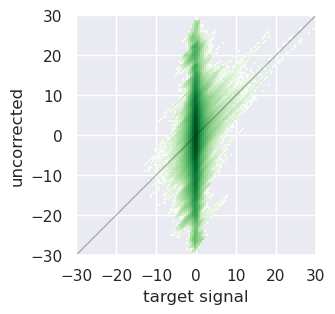

In [17]:
def list_plot_uncorrected(data, data_loader):
    # init lists
    uncorrected_array = np.array([])
    target_array = np.array([])
    
    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')
            
        igram = undo_norm(igram.squeeze().detach())
        signal_target = undo_norm(signal_target.squeeze())
        
        uncorrected_array = np.append(uncorrected_array, igram)
        target_array = np.append(target_array, signal_target)

    print('calulating r2')
    r2 = calc_r2(uncorrected_array, target_array)
    print(r2)
    
    print('plotting')
    plot_rmse(uncorrected_array, target_array, ylabel='uncorrected')

    return r2, uncorrected_array, target_array
        
r2, uncorrected_array, target_array  = list_plot_uncorrected(test_data, test_loader)

loop 500/2765
loop 1000/2765
loop 1500/2765
loop 2000/2765
loop 2500/2765
calulating r2
0.6398031510156315
plotting


/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

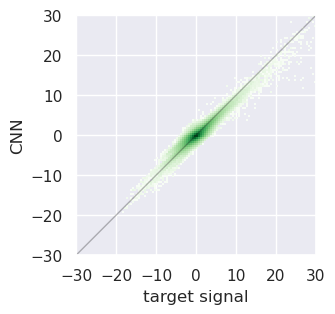

In [18]:
def list_plot_model(data, data_loader):
    # init lists
    model_array = np.array([])
    target_array = np.array([])
    
    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')
            
        noise_pred = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal_pred = torch.clamp(igram.to('cpu') - noise_pred.to('cpu'), -1, 1)
        
        signal_target = undo_norm(signal_target.squeeze())
        signal_pred = undo_norm(signal_pred.squeeze())
        
        model_array = np.append(model_array, signal_pred.detach())
        target_array = np.append(target_array, signal_target)

    print('calulating r2')
    r2 = calc_r2(model_array, target_array)
    print(r2)

    print('plotting')
    plot_rmse(model_array, target_array, ylabel='CNN')
    
    return r2, model_array, target_array

r2, model_array, target_array = list_plot_model(test_data, test_loader)

loop 500/2765
loop 1000/2765
loop 1500/2765
loop 2000/2765
loop 2500/2765
calulating r2
-4.404433714907058
plotting


/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

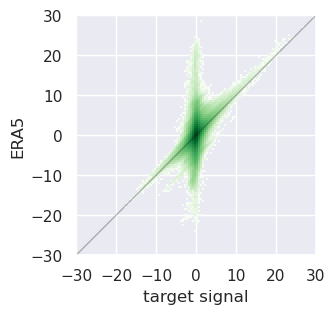

In [19]:
def list_plot_era5(data, data_loader):
    # init lists
    era5_array = np.array([])
    target_array = np.array([])
    
    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')
        
        signal_target = undo_norm(signal_target.squeeze())
        
        era5_array = np.append(era5_array, era5_corr)
        target_array = np.append(target_array, signal_target)

    print('calulating r2')
    r2 = calc_r2(era5_array, target_array)
    print(r2)

    print('plotting')
    plot_rmse(era5_array, target_array, ylabel='ERA5')
    
    return r2, era5_array, target_array

r2, era5_array, target_array = list_plot_era5(test_data, test_loader)

loop 500/2765
loop 1000/2765
loop 1500/2765
loop 2000/2765
loop 2500/2765
calulating r2
-8.6887744774348
plotting


/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

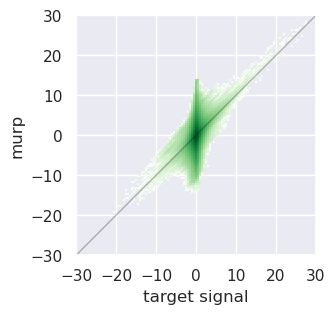

In [20]:
def list_plot_murp(data, data_loader):
    # init lists
    murp_array = np.array([])
    target_array = np.array([])
    
    for i, (igram, signal_target, noise_target, dem, murp_corr, murp_corr, hp_corr) in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')
        
        signal_target = undo_norm(signal_target.squeeze())
        
        murp_array = np.append(murp_array, murp_corr)
        target_array = np.append(target_array, signal_target)

    print('calulating r2')
    r2 = calc_r2(murp_array, target_array)
    print(r2)

    print('plotting')
    plot_rmse(murp_array, target_array, ylabel='murp')
    
    return r2, murp_array, target_array

r2, murp_array, target_array = list_plot_murp(test_data, test_loader)

loop 500/2765
loop 1000/2765
loop 1500/2765
loop 2000/2765
loop 2500/2765
calulating r2
0.3931575986133491
plotting


/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/Backups/gbrench/sw/miniconda3/envs/indennt/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

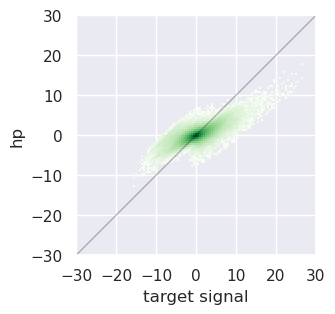

In [21]:
def list_plot_hp(data, data_loader):
    # init lists
    hp_array = np.array([])
    target_array = np.array([])
    
    for i, (igram, signal_target, noise_target, dem, hp_corr, murp_corr, hp_corr) in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')
        
        signal_target = undo_norm(signal_target.squeeze())
        
        hp_array = np.append(hp_array, hp_corr)
        target_array = np.append(target_array, signal_target)

    print('calulating r2')
    r2 = calc_r2(hp_array, target_array)
    print(r2)

    print('plotting')
    plot_rmse(hp_array, target_array, ylabel='hp')
    
    return r2, hp_array, target_array

r2, hp_array, target_array = list_plot_hp(test_data, test_loader)

uncorrected r2:
CNN r2:
era5 r2:
murp r2:
hp r2:

In [22]:
# test_ssim_df=df_for_plotting(test_snr_list, test_ssim_list_uncorrected, test_ssim_list_model, test_ssim_list_era5, test_ssim_list_murp, test_ssim_list_hp)
# #test_mse_df=df_for_plotting(test_snr_list, test_mse_list_uncorrected, test_mse_list_model, test_mse_list_era5, test_mse_list_murp, test_mse_list_hp)

In [23]:
# # can't plot exactly 0 snr due to log scale
# test_ssim_df_clean = test_ssim_df[test_ssim_df.snr != 0]
# test_mse_df_clean = test_mse_df[test_mse_df.snr != 0]

In [24]:
# sns.set_theme()

# f, ax = plt.subplots(1, 5, figsize=(10,3.5), sharex=True, sharey=True)

# # val uncorrected 
# sns.histplot(ax=ax[0], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_uncorrected, cmap='Purples', cbar=False, alpha=0)
# ax[0].set_xscale('log')

# sns.histplot(ax=ax[0], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_uncorrected, cmap='Purples', cbar=False,
#              bins=30, vmax=30, alpha=0.8)
# ax[0].set_xscale('log')
# ax[0].set_ylabel('SSIM')
# ax[0].set_xlabel('SNR')
# ax[0].set_title('uncorrected')

# sns.lineplot(ax=ax[0], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[0], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[0], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.8)

# # val model corrected
# sns.histplot(ax=ax[1], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_model, cmap='Purples', cbar=False,
#              bins=30, vmax=30, alpha=0.8)
# ax[1].set_xscale('log')
# ax[1].set_ylabel('SSIM')
# ax[1].set_xlabel('SNR')
# ax[1].set_title('CNN')

# sns.lineplot(ax=ax[1], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_model_median, size=1, c='k', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[1], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[1], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.8)

# # val era5 corrected
# sns.histplot(ax=ax[2], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_era5, cmap='Purples', cbar=False,
#              bins=30, vmax=30, alpha=0.8)
# ax[2].set_xscale('log')
# ax[2].set_ylabel('SSIM')
# ax[2].set_xlabel('SNR')
# ax[2].set_title('ERA5')

# sns.lineplot(ax=ax[2], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_era5_median, size=1, c='k', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[2], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[2], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.8)

# # val murp corrected
# sns.histplot(ax=ax[3], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_murp, cmap='Purples', cbar=False,
#              bins=30, vmax=30, alpha=0.8)
# ax[3].set_xscale('log')
# ax[3].set_ylabel('SSIM')
# ax[3].set_xlabel('SNR')
# ax[3].set_title('MuRP')

# sns.lineplot(ax=ax[3], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_murp_median, size=1, c='k', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[3], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[3], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.8)


# # val hp corrected
# sns.histplot(ax=ax[4], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_hp, cmap='Purples', cbar=False,
#              bins=30, vmax=30, alpha=0.8)
# ax[4].set_xscale('log')
# ax[4].set_xlabel('SNR')
# ax[4].set_ylabel('SSIM')
# ax[4].set_title('low-pass filter')

# sns.lineplot(ax=ax[4], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_hp_median, size=1, c='k', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[4], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.8)
# sns.lineplot(ax=ax[4], x=test_ssim_df_clean.snr, y=test_ssim_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.8)

# plt.savefig('../../figs/SSIM_SNR.png', dpi=300)

In [25]:
# sns.set_theme()

# f, ax = plt.subplots(1, 5, figsize=(10,5), sharex=True, sharey=True)

# # val uncorrected 
# sns.histplot(ax=ax[0], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')

# sns.histplot(ax=ax[0], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False,
#              bins=30, vmax=50, alpha=0.8)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].set_ylabel('MSE')
# ax[0].set_title('uncorrected')

# sns.lineplot(ax=ax[0], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_uncorrected_mean, size=1, c='k', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[0], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[0], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# # val model corrected
# sns.histplot(ax=ax[1], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_model, cmap='Oranges', cbar=False,
#              bins=30, vmax=50, alpha=0.8)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[1].set_ylabel('MSE')
# ax[1].set_title('CNN')

# sns.lineplot(ax=ax[1], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_model_mean, size=1, c='k', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[1], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[1], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# # val era5 corrected
# sns.histplot(ax=ax[2], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_era5, cmap='Oranges', cbar=False,
#              bins=30, vmax=50, alpha=0.8)
# ax[2].set_xscale('log')
# ax[2].set_yscale('log')
# ax[2].set_ylabel('MSE')
# ax[2].set_title('ERA5')

# sns.lineplot(ax=ax[2], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_era5_mean, size=1, c='k', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[2], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[2], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# # val murp corrected
# sns.histplot(ax=ax[3], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_murp, cmap='Oranges', cbar=False,
#              bins=30, vmax=50, alpha=0.8)
# ax[3].set_xscale('log')
# ax[3].set_yscale('log')
# ax[3].set_ylabel('MSE')
# ax[3].set_title('MuRP')

# sns.lineplot(ax=ax[3], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_murp_mean, size=1, c='k', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[3], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[3], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)


# # val hp corrected
# sns.histplot(ax=ax[4], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_hp, cmap='Oranges', cbar=False,
#              bins=30, vmax=50, alpha=0.8)
# ax[4].set_xscale('log')
# ax[4].set_yscale('log')
# ax[4].set_xlabel('SNR')
# ax[4].set_ylabel('MSE')
# ax[4].set_title('low-pass filter')

# sns.lineplot(ax=ax[4], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_hp_mean, size=1, c='k', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[4], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
# sns.lineplot(ax=ax[4], x=test_mse_df_clean.snr, y=test_mse_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# #plt.savefig('SSIMv2.png', dpi=300)

In [26]:
# # convert to long format for more plotting
# ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
# test_ssim_long = pd.melt(test_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
# test_ssim_long['dataset'] = 'test'

# # convert to long format for more plotting
# ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
# test_mse_long = pd.melt(test_mse_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='mse')
# test_mse_long['dataset'] = 'test'

In [27]:
# #histplots 
# sns.set_theme()
# f, ax = plt.subplots(1, 1, figsize=(7,3))

# sns.kdeplot(ax=ax, data=test_ssim_long, x='ssim', hue='corr_type', 
#             hue_order=['ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp', 'ssim_uncorrected'], 
#             palette=['blue', 'orange', 'gold', 'peru', 'red'], fill=True, legend=False)

# ax.set_xlim((-0.25, 0.8))
# ax.set_xlabel('SSIM')
# ax.set_ylabel('kernel density')
# f.tight_layout()
# plt.savefig('../../figs/ssim_kde.png', dpi=300)

In [28]:
# #histplots 
# sns.set_theme()
# f, ax = plt.subplots(1, 1, figsize=(8,3))

# sns.kdeplot(ax=ax, data=test_mse_long, x='mse', hue='corr_type', 
#             hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
#             palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

# ax.set_xlim((-0.25, 1))
# ax.set_xlabel('MSE')
# ax.set_ylabel('kernel density')
# f.tight_layout()
# #plt.savefig('ssim_kde.png', dpi=300)

### Stats

In [29]:
# # test if data are normally distributed
# print('test uncorrected: ', stats.kstest(test_ssim_df['ssim_uncorrected'].values, stats.norm.cdf))
# print('test model: ', stats.kstest(test_ssim_df['ssim_model'].values, stats.norm.cdf))
# print('test era5: ', stats.kstest(test_ssim_df['ssim_era5'].values, stats.norm.cdf))
# print('test MuRP: ', stats.kstest(test_ssim_df['ssim_murp'].values, stats.norm.cdf))
# print('test hp: ', stats.kstest(test_ssim_df['ssim_hp'].values, stats.norm.cdf))

# #they are not even close to normal

In [30]:
# # wilcoxon signed rank test to compare paired samples
# stats.wilcoxon(test_ssim_df['ssim_uncorrected'].values, test_ssim_df['ssim_model'].values, nan_policy='omit')

In [31]:
# # wilcoxon signed rank test to compare paired samples
# stats.wilcoxon(test_ssim_df['ssim_model'].values, test_ssim_df['ssim_era5'].values, nan_policy='omit')

In [32]:
# # wilcoxon signed rank test to compare paired samples
# stats.wilcoxon(test_ssim_df['ssim_model'].values, test_ssim_df['ssim_hp'].values, nan_policy='omit')

In [33]:
# # wilcoxon signed rank test to compare paired samples
# stats.wilcoxon(test_ssim_df['ssim_model'].values, test_ssim_df['ssim_murp'].values, nan_policy='omit')